In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Dynamically add project root to sys.path
PROJECT_ROOT = os.path.abspath("..")  # Adjust if necessary
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Verify sys.path
print("Project root added to sys.path:", PROJECT_ROOT)

from utils.config import *


plt.rcParams.update({
    'axes.titlesize': 22,            # Font size for the plot titles
    'axes.labelsize': 20,            # Font size for the x and y labels
    'legend.fontsize': 16,           # Font size for the legend
    'xtick.labelsize': 20,           # Font size for the x-tick labels
    'ytick.labelsize': 20,           # Font size for the y-tick labels
    'axes.linewidth': 3.5,           # Width of the axes' lines
    'xtick.major.width': 3.25,       # Width of the major x-tick lines
    'ytick.major.width': 3.25,       # Width of the major y-tick lines
    'xtick.minor.width': 4.0,        # Width of the minor x-tick lines
    'ytick.minor.width': 4.0,        # Width of the minor y-tick lines
    'figure.titlesize': 20,          # Font size for figure titles
    'legend.handlelength': 2,        # Length of the legend lines
    'legend.handleheight': 0.7,      # Height of the legend markers
    'legend.labelspacing': 0.5,      # Vertical spacing between legend entries
    'lines.linewidth': 3.0,          # Line width for plot lines
    'lines.markersize': 3,           # Size of markers in plot lines
    'axes.grid': False,               # Enable grid on all plots
    'grid.alpha': 0.75,              # Set gridline transparency
    'grid.linestyle': '--',          # Set gridline style
    'grid.linewidth': 0.7,           # Set gridline width
    'grid.color': 'gray',            # Set gridline color
})

Project root added to sys.path: /feynman/work/dap/lcs/vt272285/Generative modelling of convergence map
Global imports loaded successfully!


In [2]:
def load_takahashi_file(filename):
        skip = [0, 536870908, 1073741818, 1610612728, 2147483638, 2684354547, 3221225457]
        load_blocks = [skip[i+1]-skip[i] for i in range(0, 6)]
        with open(filename, 'rb') as f:
            rec = np.fromfile(f, dtype='uint32', count=1)[0]
            nside = np.fromfile(f, dtype='int32', count=1)[0]
            npix = np.fromfile(f, dtype='int64', count=1)[0]
            rec = np.fromfile(f, dtype='uint32', count=1)[0]
            print("nside:{} npix:{}".format(nside, npix))

            rec = np.fromfile(f, dtype='uint32', count=1)[0]
            print("file opened!")
            kappa = np.array([])
            r = npix
            for i, l in enumerate(load_blocks):
                blocks = min(l, r)
                load = np.fromfile(f, dtype='float32', count=blocks)
                np.fromfile(f, dtype='uint32', count=2)
                kappa = np.append(kappa, load)
                r = r-blocks
                if r == 0:
                    break
                elif r > 0 and i == len(load_blocks)-1:
                    load = np.fromfile(f, dtype='float32', count=r)
                    np.fromfile(f, dtype='uint32', count=2)
                    kappa = np.append(kappa, load)

        # nside_takahashi = new_nside
        # kappa_1024 = hp.pixelfunc.ud_grade(kappa, nside_takahashi)
        return kappa

# filename = "/feynman/work/dap/lcs/vt272285/data/sim_data/Takahashi/allskymap_nres12r000.zs25.mag.dat"
filename = "/feynman/work/dap/lcs/vt272285/data/sim_data/Takahashi/allskymap_nres12r000.zs25.mag.dat"
kappa_original = load_takahashi_file(filename)

nside:4096 npix:201326592
file opened!


In [3]:
def downgrage_map(map, nside):
    return hp.pixelfunc.ud_grade(map, nside)

def get_cls_from_map(map, nside, lmax):
    return hp.anafast(map, lmax=lmax, pol=True, use_pixel_weights=True)

def get_pixel_wf_ells(nside, lmax):
    ells = np.arange(lmax+1)
    pw =  hp.pixwin(nside, lmax=lmax)
    return pw, ells

def get_cls(map, lmax):
    return hp.anafast([map], pol=True, lmax=lmax, use_pixel_weights=True)



In [4]:
def adjust_cls(nside_map, lmax_map, map, target_ells, target_cls):
    if lmax_map is None:
        lmax_map = 3*nside_map + 1
    ells_map = np.arange(lmax_map+1)
    cls_map = get_cls(map, lmax_map)
    map_alm = hp.map2alm(map, lmax=lmax_map)
    interp_func_target = interp1d(target_ells, target_cls, kind="linear", bounds_error=False, fill_value="extrapolate")
    interpolated_cls_target = interp_func_target(ells_map)
    scale_factor = np.sqrt(interpolated_cls_target/cls_map)
    map_alm_scaled = hp.almxfl(map_alm, scale_factor)
    map_scaled = hp.alm2map(map_alm_scaled, nside=nside_map, lmax=lmax_map)
    return map_scaled


In [5]:
def get_gaussian_map(nside, lmax):
    variance = 0.01
    alm_real = np.random.normal(0, np.sqrt(variance), hp.Alm.getsize(lmax))  # Real part
    alm_imag = np.random.normal(0, np.sqrt(variance), hp.Alm.getsize(lmax))  # Imaginary part
    alm = alm_real + 1j * alm_imag  # Combine into complex numbers
    map_gaussian = hp.alm2map(alm, nside=nside, lmax=lmax)
    # Normalize map to have the desired variance
    map_gaussian = (map_gaussian - np.mean(map_gaussian))  # Zero mean
    map_gaussian = map_gaussian / np.std(map_gaussian) * np.sqrt(variance)  # Adjust variance
    return map_gaussian

In [6]:
def get_beam(theta, lmax):
    """Compute a top-hat beam function in harmonic space."""
    def top_hat(b, radius):
        return np.where(np.abs(b) <= radius, 1 / (np.cos(radius) - 1) / (-2 * np.pi), 0)

    t = theta * np.pi / (60 * 180)  # Convert arcminutes to radians
    b = np.linspace(0.0, t * 1.2, 10000)
    bw = top_hat(b, t)
    return hp.sphtfunc.beam2bl(bw, b, lmax)  

def tophat_decompose(map, nside, lmax, pixel_resolution, nscales):
    """Decomposes a HEALPix map using top-hat smoothing at multiple scales."""
    coarse_map = map.copy()
    scale_maps = []
    pixel_resolution = hp.nside2resol(nside, arcmin=True)
    # Compute the spherical harmonics of the original map ONCE
    alm_coarse = hp.map2alm(coarse_map, lmax=lmax)

    # Precompute all beam functions
    beam_filters = [get_beam(pixel_resolution * (2**i), lmax) for i in range(1, nscales+1)]

    for beam in beam_filters:
        # Apply beam in alm space
        alm_smooth = hp.almxfl(alm_coarse, beam)
        map_smooth = hp.alm2map(alm_smooth, nside, lmax=lmax)
        
        # Compute scale coefficients
        map_coef = coarse_map - map_smooth
        coarse_map = map_smooth
        scale_maps.append(map_coef)

    # Append the coarsest scale
    scale_maps.append(coarse_map)

    return scale_maps


In [7]:
def calculate_histogram_l1norm(image, mask, nbins, density=True):
    """
    Calculates the histogram and L1 norm of an image while accounting for a mask.
    
    Parameters:
        image (np.ndarray): The input image.
        mask (np.ndarray): The mask to apply on the image (1 for valid pixels, 0 to ignore).
        nbins (int or array-like): Number of bins or bin edges for the histogram.
        density (bool): Whether to compute a density-normalized histogram.
    
    Returns:
        binedges (np.ndarray): The edges of the bins.
        bincenters (np.ndarray): The center of each bin.
        hist (np.ndarray): The histogram values for each bin.
        bin_l1_norm (list): The L1 norm for each bin.
    """
    # If no mask is provided, assume all pixels are valid
    if mask is None:
        mask = np.ones_like(image, dtype=bool)
        
    # Apply the mask to filter out invalid pixels
    masked_image = image[mask]

    # Define bin edges and centers
    if np.ndim(nbins) > 0:  # If nbins is an array, treat it as bin edges
        binedges = np.asarray(nbins)
    else:  # Otherwise, generate bin edges using the range of the masked image
        binedges = np.linspace(np.min(masked_image), np.max(masked_image), nbins + 1)
    
    bincenters = 0.5 * (binedges[:-1] + binedges[1:])
    
    # Calculate the histogram using only the masked pixels
    hist, _ = np.histogram(masked_image, bins=binedges, density=density)
    
    # Calculate the bin width (for normalization if density=True)
    bin_width = binedges[1] - binedges[0]
    total_pixels = np.prod(image.shape)
    
    # Digitize the masked image to determine bin membership
    digitized = np.digitize(masked_image, binedges, right=False)
    
    # Calculate the L1 norm per bin
    bin_l1_norm = [
        np.sum(np.abs(masked_image[digitized == i])) / (total_pixels * bin_width) if density else
        np.sum(np.abs(masked_image[digitized == i]))
        for i in range(1, len(binedges))
    ]
    return np.array(binedges), np.array(bincenters), np.array(hist), np.array(bin_l1_norm)

def process_image(mask,map, nscales, nbins, nside, lmax):
    _, ells = get_pixel_wf_ells(nside, lmax)
    pixel_res = hp.nside2resol(nside, arcmin=True)
    if mask is None:
        mask = np.ones_like(map, dtype=bool)
        
    values = {}

    # Compute the power spectrum of the target map
    cls = get_cls_from_map(map, nside, lmax) 

    # Decompose the target map into wavelet coefficients
    coefs = tophat_decompose(map, nside, lmax, pixel_res, nscales)
        
    # Process each scale and compute histograms, L1 norms, etc.
    for scale in range(nscales + 1):
        sigma = np.std(coefs[scale])
        edges, centers, hist, l1_norm = calculate_histogram_l1norm(
            coefs[scale], mask, nbins[scale]
        )
        values[f'scale_{scale}'] = {
            'histogram': hist,
            'binedges': edges,
            'l1_norm': l1_norm,
            'bincenters': centers,
            'sigma': sigma
        }

    # Add power spectrum information
    values['cls'] = cls
    values['ells'] = ells
    values['pixel_res'] = pixel_res
    values['coefs'] = coefs
    return values



In [8]:
def adjust_map_l1(input_image, mask, targetvalues):
    """
    Adjusts wavelet coefficients of an input image to match the target histogram 
    and L1 norm per bin.

    Parameters:
    - input_image (2D array): Input wavelet coefficient map for a given scale.
    - mask (2D array): Boolean mask indicating which coefficients should be modified.
    - targetvalues (dict): Dictionary containing target statistics:
        - 'histogram' (1D array): Target histogram (normalized to sum to 1).
        - 'binedges' (1D array): Bin edges.
        - 'l1_norm' (1D array): Target L1 norm per bin.
        - 'bincenters' (1D array): Bin centers.

    Returns:
    - adjusted_image (2D array): Adjusted wavelet coefficient map.
    """
    # Retrieve target statistics
    bin_edges = targetvalues['binedges']
    scaling_factor = input_image.shape[0]*(bin_edges[1]-bin_edges[0])
    target_histogram = targetvalues['histogram']*scaling_factor
    target_l1_norm = targetvalues['l1_norm']*scaling_factor
    
    if mask is None:
        mask = np.ones_like(input_image)
        
    # Extract coefficients using the mask
    totpixels = np.prod(input_image.shape)
    totmaskedpixels = np.count_nonzero(mask)
    mask_indices = np.nonzero(mask)  # Indices of valid (non-zero mask) pixels

    ratio_masked_field = totmaskedpixels / totpixels
    
    input_masked = input_image[mask_indices]
    sorted_indices = np.argsort(input_masked)
    
    start_idx = 0
    num_bins = len(target_histogram)
    
    total_l1_error = 0.0
    for bin_idx in range(num_bins):
        # Compute the number of coefficients to allocate to this bin
        num_coeffs_in_bin = round(target_histogram[bin_idx] * ratio_masked_field)
        end_idx = start_idx + num_coeffs_in_bin

        # Ensure the last bin includes all remaining coefficients
        if bin_idx == num_bins - 1:
            end_idx = totmaskedpixels
        elif end_idx > totmaskedpixels:
            end_idx = totmaskedpixels

        # Get bin boundaries and target L1 norm
        bin_min = bin_edges[bin_idx]
        bin_max = bin_edges[bin_idx + 1]
        target_l1_bin = target_l1_norm[bin_idx] * ratio_masked_field

        if num_coeffs_in_bin > 0 and end_idx > start_idx:
            start_idx = int(start_idx)
            end_idx = int(end_idx)

            # Extract coefficients in this bin
            coeffs_in_bin = input_masked[sorted_indices[start_idx:end_idx]]

            # Compute current L1 norm in this bin
            current_l1_bin = np.sum(np.abs(coeffs_in_bin))
            delta_bin_value = (target_l1_bin - current_l1_bin) / num_coeffs_in_bin

            # Adjust positive values
            pos_indices = np.where(coeffs_in_bin >= 0)[0]
            if len(pos_indices) > 0:
                coeffs_in_bin[pos_indices] += delta_bin_value
                coeffs_in_bin[pos_indices] = np.maximum(coeffs_in_bin[pos_indices], 0)

            # Recalculate L1 norm
            current_l1_bin = np.sum(np.abs(coeffs_in_bin))

            # Adjust negative values
            neg_indices = np.where(coeffs_in_bin < 0)[0]
            if len(neg_indices) > 0:
                neg_adjustment = (target_l1_bin - current_l1_bin) / len(neg_indices)
                coeffs_in_bin[neg_indices] -= neg_adjustment
                coeffs_in_bin[neg_indices] = np.minimum(coeffs_in_bin[neg_indices], 0)

            # Enforce final boundary constraints
            index = np.where(coeffs_in_bin < bin_min)[0]
            if len(index) > 0:
                coeffs_in_bin[index] = bin_min
            index = np.where(coeffs_in_bin > bin_max)[0]
            if len(index) >0:
                coeffs_in_bin[index] = bin_max
            # coeffs_in_bin = np.clip(coeffs_in_bin, bin_min, bin_max)
            
            # Compute L1 norm error for diagnostics
            current_l1_bin = np.sum(np.abs(coeffs_in_bin))
            total_l1_error += np.abs(target_l1_bin - current_l1_bin)

            # Update sorted coefficients
            input_masked[sorted_indices[start_idx:end_idx]] = coeffs_in_bin
            
        start_idx += num_coeffs_in_bin
    # Restore the adjusted coefficients into the original image
    adjusted_image = np.copy(input_image)
    adjusted_image[mask_indices] = input_masked  

    return adjusted_image, total_l1_error /np.max(target_l1_norm)


Time taken to generate gaussian map for nside: 256 is, 0.036200523376464844s
iter 0 error: 11.85209410323515
iter 1 error: 3.4954717499996777
iter 2 error: 2.301287000238009
iter 3 error: 1.656248249756971
iter 4 error: 1.2496870232081796
iter 5 error: 0.978293360239695
iter 6 error: 0.778231233487389
iter 7 error: 0.631318469222902
iter 8 error: 0.5209246992264654
iter 9 error: 0.43787763205371266
iter 10 error: 0.3797778169746545
iter 11 error: 0.33831143820134424
iter 12 error: 0.3078312228956045
iter 13 error: 0.28366135663961584
iter 14 error: 0.26699809104126904
iter 15 error: 0.25503547323236014
iter 16 error: 0.24461984014100208
iter 17 error: 0.2363092421869579
iter 18 error: 0.2298541871002523
iter 19 error: 0.2240152202613066
iter 20 error: 0.2199487194548146
iter 21 error: 0.2169228218981959
iter 22 error: 0.2146950353936624
iter 23 error: 0.2129651163442589
iter 24 error: 0.21126670094526928
iter 25 error: 0.21006579368522982
iter 26 error: 0.20880042968751253
iter 27 erro

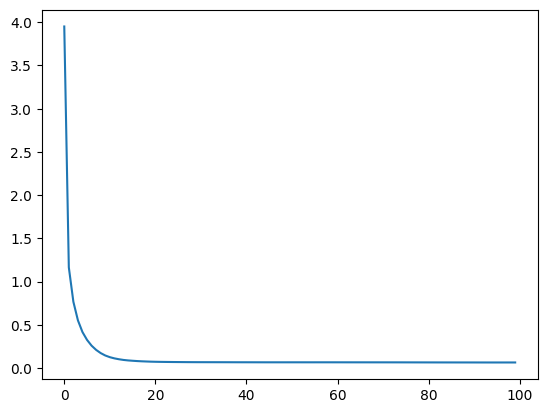

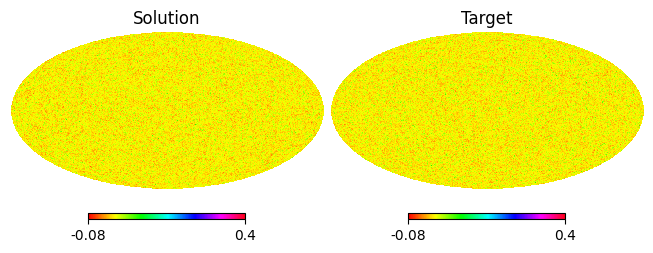

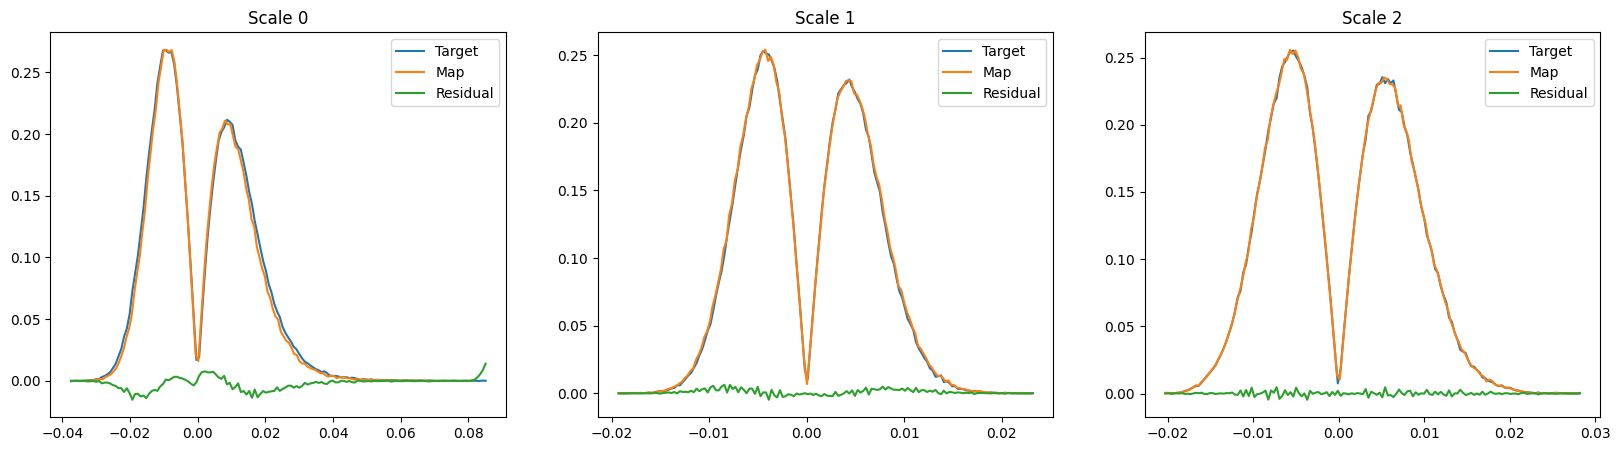

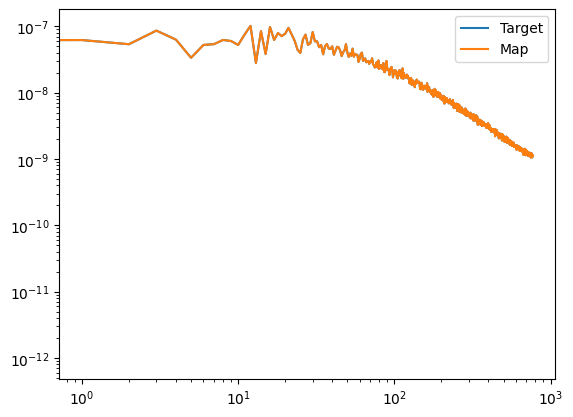

In [10]:
nside_target = 256
lmax_target = 3*nside_target + 1

kappa = downgrage_map(kappa_original, nside_target)

nside_map = nside_target
lmax_map = 3*nside_map +1

start_time = time.time()
map_gaussian = get_gaussian_map(nside_map, lmax_map)
end_time = time.time()
print(f"Time taken to generate gaussian map for nside: {nside_map} is, {end_time - start_time}s")

nscales = 2
nbins = [150,150,150,150,150]

target_values = process_image(None, kappa, nscales, nbins, nside_target, lmax_target)

solution = map_gaussian
pixel_res = hp.nside2resol(nside_map, arcmin=True)
tot_error = []
for i in range(100):
    solution_coefs = tophat_decompose(solution, nside_map, lmax_map, pixel_res, nscales)
    tot_err = 0
    for scale in range( nscales + 1):
        solution_coefs[scale], err = adjust_map_l1(solution_coefs[scale], None, target_values[f'scale_{scale}'])
        tot_err += err
    tot_error.append(tot_err*100 / (nscales + 1))  
    print(f"iter {i} error: {tot_err*100}")
    solution_l1 = np.sum(solution_coefs, axis=0)
    solution_cls = adjust_cls(nside_map, lmax_map, solution, target_values['ells'], target_values['cls'])

    solution = 0.5 * (solution_cls + solution_l1)

    # if i>10 and np.average(tot_error[-10:]) < 0.5:
    #     print("Reached Convergence")
    #     break

# solution = decomposer.reconstruct(solution_coefs)
plt.plot(tot_error)
plt.show()

vmin = -0.08
vmax = 0.4
hp.mollview(solution, title="Solution", min=vmin, max=vmax, sub=(1,2,1), cmap='hsv')
hp.mollview(kappa, title="Target", min=vmin, max=vmax, sub=(1,2,2), cmap='hsv')
plt.show()

solution_values = process_image(None, solution, nscales, nbins, nside_map, lmax_map)

fig, axs = plt.subplots(1, nscales + 1, figsize=(20, 5))
for scale in range(nscales+1):
    centers_target = target_values[f'scale_{scale}']['bincenters']
    centers_solution = solution_values[f'scale_{scale}']['bincenters']
    l1norm_target = target_values[f'scale_{scale}']['l1_norm']
    l1norm_solution = solution_values[f'scale_{scale}']['l1_norm']
    l1norm_solution_spline = CubicSpline(centers_solution, l1norm_solution)
    axs[scale].plot(target_values[f'scale_{scale}']['bincenters'], target_values[f'scale_{scale}']['l1_norm'], label='Target')
    axs[scale].plot(solution_values[f'scale_{scale}']['bincenters'], solution_values[f'scale_{scale}']['l1_norm'], label='Map')
    axs[scale].plot(centers_target, (l1norm_solution_spline(centers_target) - l1norm_target), label='Residual')
    axs[scale].set_title(f'Scale {scale}')
    axs[scale].legend()
plt.show()

plt.figure()
plt.loglog(solution_values['ells'], solution_values['cls'], label="Target")
plt.loglog(solution_values['ells'], solution_values['cls'], label="Map")
plt.legend()
plt.show()



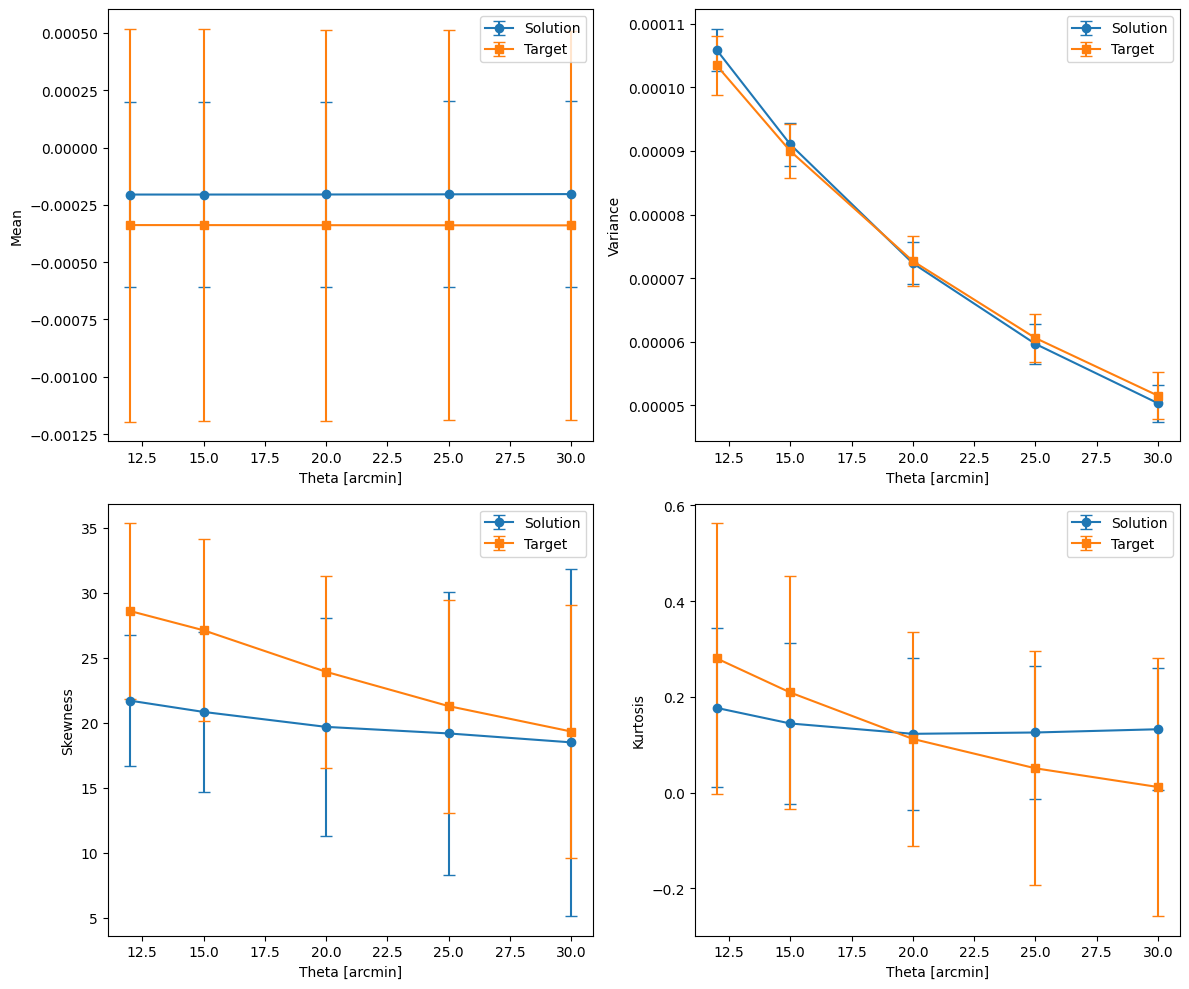

In [14]:
def get_top_hat_filtered_maps(map, nside, lmax, beam_filter):
    """Applies a top-hat filter to the map in harmonic space."""
    alm_map = hp.map2alm(map, lmax=lmax)
    alm_smooth = hp.almxfl(alm_map, beam_filter)
    map_smooth = hp.alm2map(alm_smooth, nside, lmax=lmax)
    return map_smooth

def get_moments_from_map(map_values):
    """
    Calculates the moments (mean, variance, skewness, kurtosis) from a 2D map.

    Parameters:
        map_values (numpy.ndarray): A 2D array representing the map values (e.g., convergence, density field).

    Returns:
        tuple: Contains mean, variance, skewness, kurtosis of the map values.
    """
    # Flatten the map to treat it as a distribution of values
    flattened_values = map_values.flatten()

    # Calculate the mean
    mean_value = np.mean(flattened_values)

    # Calculate the variance (second central moment)
    variance = np.var(flattened_values)

    # Calculate the third moment (skewness numerator)
    third_moment = np.mean((flattened_values - mean_value) ** 3)

    # Calculate the fourth moment (kurtosis numerator)
    fourth_moment = np.mean((flattened_values - mean_value) ** 4)

    # Skewness: third moment divided by variance squared
    skewness = third_moment / (variance ** 2)

    # Kurtosis: fourth moment divided by variance squared, minus 3 for excess kurtosis
    kurtosis = (fourth_moment / (variance ** 2)) - 3.0

    return mean_value, variance, skewness, kurtosis

def get_patch_variances(map_smooth, nside, npatches=6):
    """Divides the HEALPix map into patches and computes variance for each patch."""
    npix = hp.nside2npix(nside)
    base_nside = 3  # HEALPix base resolution (12 base pixels)
    
    # Select 6 patches from 12 base pixels
    patch_indices = [0, 1, 2, 3, 4]
    moments = []

    for base_pix in patch_indices:
        # Get boundaries (vertices) of the base pixel
        vertices = hp.boundaries(base_nside, base_pix, step=1, nest=False).T
        
        # Query pixels in this region
        pixels_in_patch = hp.query_polygon(nside, vertices, inclusive=True)

        # Compute variance in this patch
        patch_values = map_smooth[pixels_in_patch]
        moments.append(get_moments_from_map(patch_values))

    return moments  # Error estimate from patch variances

# Parameters
thetas = [ 12, 15, 20, 25, 30]
beam_filters_th = [get_beam(thetas[i], lmax_target) for i in range(len(thetas))]

moments_solution = []
moments_target = []

for i in range(len(thetas)):
    # Compute for solution map
    map_smooth_sol = get_top_hat_filtered_maps(solution, nside_target, lmax_target, beam_filters_th[i])
    moments_sol = get_patch_variances(map_smooth_sol, nside_target)
    moments_solution.append(moments_sol)

    # Compute for target map
    map_smooth_tar = get_top_hat_filtered_maps(kappa, nside_target, lmax_target, beam_filters_th[i])
    moments_tar = get_patch_variances(map_smooth_tar, nside_target)
    moments_target.append(moments_tar)
    
moments_solution = np.array(moments_solution)
moments_target = np.array(moments_target)#

# Compute mean and standard deviation across patches for each theta
means_sol = np.mean(moments_solution, axis=1) 
errors_sol = np.std(moments_solution, axis=1)  

means_tar = np.mean(moments_target, axis=1) 
errors_tar = np.std(moments_target, axis=1)  

# Labels for the moments
moment_labels = ["Mean", "Variance", "Skewness", "Kurtosis"]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axs.flatten()):
    ax.errorbar(thetas, means_sol[:, i], yerr=errors_sol[:, i], label="Solution", fmt='o-', capsize=4)
    ax.errorbar(thetas, means_tar[:, i], yerr=errors_tar[:, i], label="Target", fmt='s-', capsize=4)
    ax.set_xlabel("Theta [arcmin]")
    ax.set_ylabel(moment_labels[i])
    ax.legend()

plt.tight_layout()
plt.show()

In [15]:
def wiener_deconvolution(kappa_smooth, beam, theory_cls, lmax, nside, noise_cls=None):
    """
    Perform Wiener deconvolution on a HEALPix map.
    
    Parameters:
    - kappa_smooth: Filtered map to deconvolve (input HEALPix map).
    - beam: Beam function (B_l).
    - theory_cls: Theoretical signal power spectrum (C_l^signal).
    - lmax: Maximum multipole moment.
    - nside: HEALPix resolution parameter.
    - noise_cls: Optional noise power spectrum (N_l). Default is zeros.
    
    Returns:
    - kappa_deconv: Deconvolved HEALPix map.
    """
    # Set noise power spectrum to zero if not provided
    if noise_cls is None:
        noise_cls = np.zeros(lmax + 1)

    # Compute spherical harmonics of the smoothed map
    alm_smooth = hp.map2alm(kappa_smooth, lmax=lmax)

    # Compute Wiener filter in harmonic space
    wiener_filter = beam / (beam**2 + noise_cls / theory_cls)

    # Apply Wiener filter to the smoothed alm
    alm_deconv = hp.almxfl(alm_smooth, wiener_filter)

    # Convert back to HEALPix map
    kappa_deconv = hp.alm2map(alm_deconv, nside, lmax=lmax)

    return kappa_deconv

In [16]:
def tophat_decompose_(map, nside, lmax, nscales, beam_filters):
    """Decomposes a HEALPix map using top-hat smoothing at multiple scales
    such that each scale is computed as map * beam_i - map * beam_{i+1}.
    
    The final scale is simply map * beam_final.
    """
    scale_maps = []

    # Compute the spherical harmonics of the original map ONCE
    alm_map = hp.map2alm(map, lmax=lmax)

    # Apply the first beam
    alm_smooth_prev = hp.almxfl(alm_map, beam_filters[0])

    for i in range(nscales):
        # Apply the next beam
        alm_smooth_curr = hp.almxfl(alm_map, beam_filters[i+1])
        
        # Convert both to real-space maps
        map_smooth_prev = hp.alm2map(alm_smooth_prev, nside, lmax=lmax)
        map_smooth_curr = hp.alm2map(alm_smooth_curr, nside, lmax=lmax)
        
        # Compute scale coefficients
        map_coef = map_smooth_prev - map_smooth_curr
        scale_maps.append(map_coef)

        # Update previous smoothing for next iteration
        alm_smooth_prev = alm_smooth_curr

    # Final scale is just the last smoothed map
    scale_maps.append(hp.alm2map(alm_smooth_prev, nside, lmax=lmax))

    return scale_maps

def process_image_(mask, map, nscales, nbins, nside, lmax, beam_filters):
    _, ells = get_pixel_wf_ells(nside, lmax)
    pixel_res = hp.nside2resol(nside, arcmin=True)
    if mask is None:
        mask = np.ones_like(map, dtype=bool)
        
    values = {}

    # Compute the power spectrum of the target map
    cls = get_cls_from_map(map, nside, lmax) 

    # Decompose the target map into wavelet coefficients
    coefs = tophat_decompose_(map, nside, lmax, nscales, beam_filters)
        
    # Process each scale and compute histograms, L1 norms, etc.
    for scale in range(nscales + 1):
        sigma = np.std(coefs[scale])
        edges, centers, hist, l1_norm = calculate_histogram_l1norm(
            coefs[scale], mask, nbins[scale]
        )
        values[f'scale_{scale}'] = {
            'histogram': hist,
            'binedges': edges,
            'l1_norm': l1_norm,
            'bincenters': centers,
            'sigma': sigma
        }

    # Add power spectrum information
    values['cls'] = cls
    values['ells'] = ells
    values['pixel_res'] = pixel_res
    values['coefs'] = coefs
    return values

nside:4096 npix:201326592
file opened!
6.870972823634812


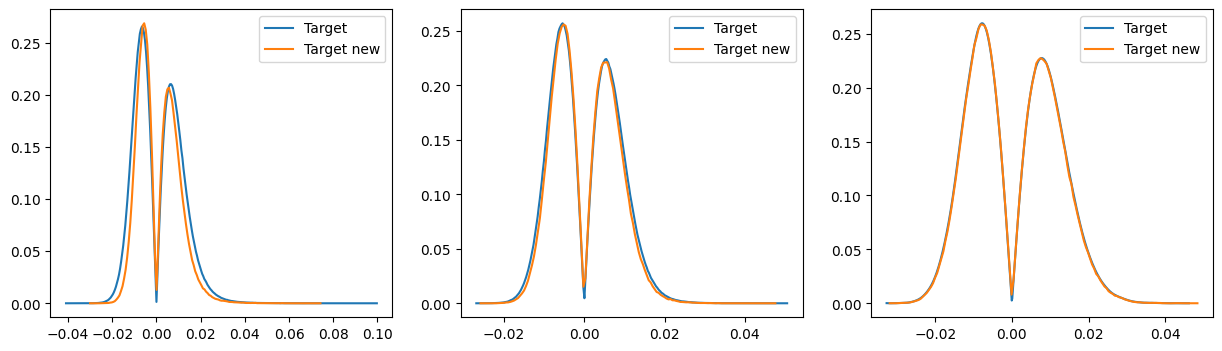

In [17]:
filename = "/feynman/work/dap/lcs/vt272285/data/sim_data/Takahashi/allskymap_nres12r000.zs25.mag.dat"
kappa_original = load_takahashi_file(filename)

nside_target = 512
lmax_target = 3*nside_target +1
pixres = hp.nside2resol(nside_target, arcmin=True)

print(hp.nside2resol(nside_target, arcmin=True))
kappa = downgrage_map(kappa_original, nside_target)

nscales = 2
nbins = [150,150,150,150,150, 150, 150]
beam_filters = [get_beam(pixres * (2**i), lmax_target) for i in range(0, nscales+1)]

# for i in range(1, nscales+1):
#     print(f"scale_{i}, theta2 : {pixres*(2**i)}")

predw1 = np.load("/feynman/work/dap/lcs/vt272285/LDT_2cell_l1_norm/takahashi_for_emulator/theory_values_2_0548_6.870972823634812.npy")
predw1_centers = -predw1.T[0]
sorted_indices = np.argsort(predw1_centers)
predw1_centers = predw1_centers[sorted_indices]
predw1_l1 = predw1.T[3][sorted_indices]
predw1_hist = predw1.T[1][sorted_indices]

predw2 = np.load("/feynman/work/dap/lcs/vt272285/LDT_2cell_l1_norm/takahashi_for_emulator/theory_values_2_0548_13.741945647269624.npy")
predw2_centers = -predw2.T[0]
sorted_indices = np.argsort(predw2_centers)
predw2_centers = predw2_centers[sorted_indices]
predw2_l1 = predw2.T[3][sorted_indices]
predw2_hist = predw2.T[1][sorted_indices]

predc2 = np.load("/feynman/work/dap/lcs/vt272285/LDT_2cell_l1_norm/takahashi_for_emulator/theory_values_2_0548_13.741945647269624_coarse.npy")
predc2_centers = predc2.T[0]
sorted_indices = np.argsort(predc2_centers)
predc2_l1 = predc2.T[3][sorted_indices]
predc2_hist = predc2.T[1][sorted_indices]


def compute_bin_edges(bin_centers):
    """Compute bin edges from bin centers assuming uniform spacing."""
    if len(bin_centers) < 2:
        return None  # Not enough points to compute edges
    
    midpoints = (bin_centers[:-1] + bin_centers[1:]) / 2
    first_edge = 2 * bin_centers[0] - midpoints[0]
    last_edge = 2 * bin_centers[-1] - midpoints[-1]
    
    return np.hstack([[first_edge], midpoints, [last_edge]])

# Compute bin edges
predw1_edges = compute_bin_edges(predw1_centers)
predw2_edges = compute_bin_edges(predw2_centers)
predc2_edges = compute_bin_edges(predc2_centers)

# Construct target_values dictionary
target_values = {}
target_values['scale_0'] = {
    'histogram': predw1_hist,
        'binedges': predw1_edges,
        'l1_norm': predw1_l1,
        'bincenters': predw1_centers,
        'sigma': None
}
target_values['scale_1'] = {
    'histogram': predw2_hist,
        'binedges': predw2_edges,
        'l1_norm': predw2_l1,
        'bincenters': predw2_centers,
        'sigma': None
}
target_values['scale_2'] = {
    'histogram': predc2_hist,
        'binedges': predc2_edges,
        'l1_norm': predc2_l1,
        'bincenters': predc2_centers,
        'sigma': None
}

pw, ells = get_pixel_wf_ells(nside_target, lmax_target)
kappa_cls = get_cls_from_map(kappa, nside_target, lmax_target)
target_values['cls'] = kappa_cls
target_values['ells'] = ells

target_values_ = process_image_(None, kappa, nscales, nbins, nside_target, lmax_target, beam_filters)
# target_values_ = process_image(None, kappa, nscales, nbins, nside_target, lmax_target)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
scale = 'scale_0'
plt.plot(target_values[scale]['bincenters'], target_values[scale]['l1_norm'], label='Target')
plt.plot(target_values_[scale]['bincenters'], target_values_[scale]['l1_norm'], label='Target new')
plt.legend()

plt.subplot(1,3,2)
scale = 'scale_1'
plt.plot(target_values[scale]['bincenters'], target_values[scale]['l1_norm'], label='Target')
plt.plot(target_values_[scale]['bincenters'], target_values_[scale]['l1_norm'], label='Target new')
plt.legend()

plt.subplot(1,3,3)
scale = 'scale_2'
plt.plot(target_values[scale]['bincenters'], target_values[scale]['l1_norm'], label='Target')
plt.plot(target_values_[scale]['bincenters'], target_values_[scale]['l1_norm'], label='Target new')
plt.legend()



Time taken to generate gaussian map for nside: 512 is, 0.1785259246826172s


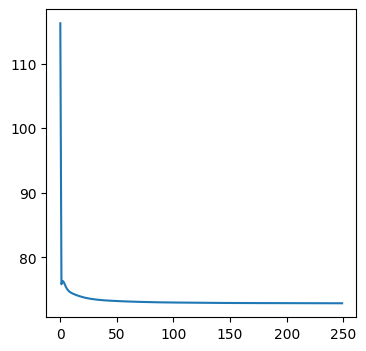

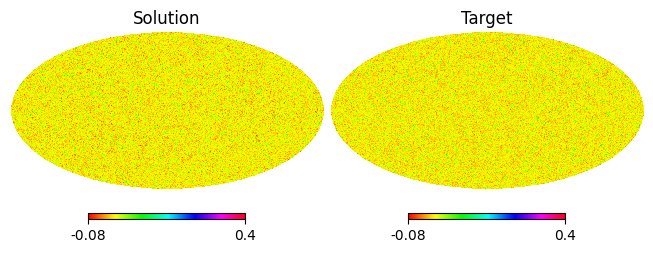

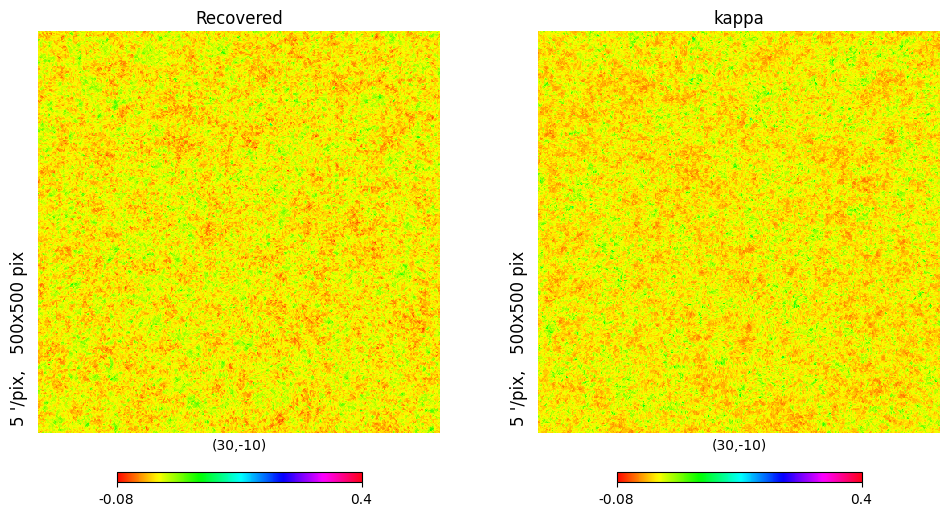

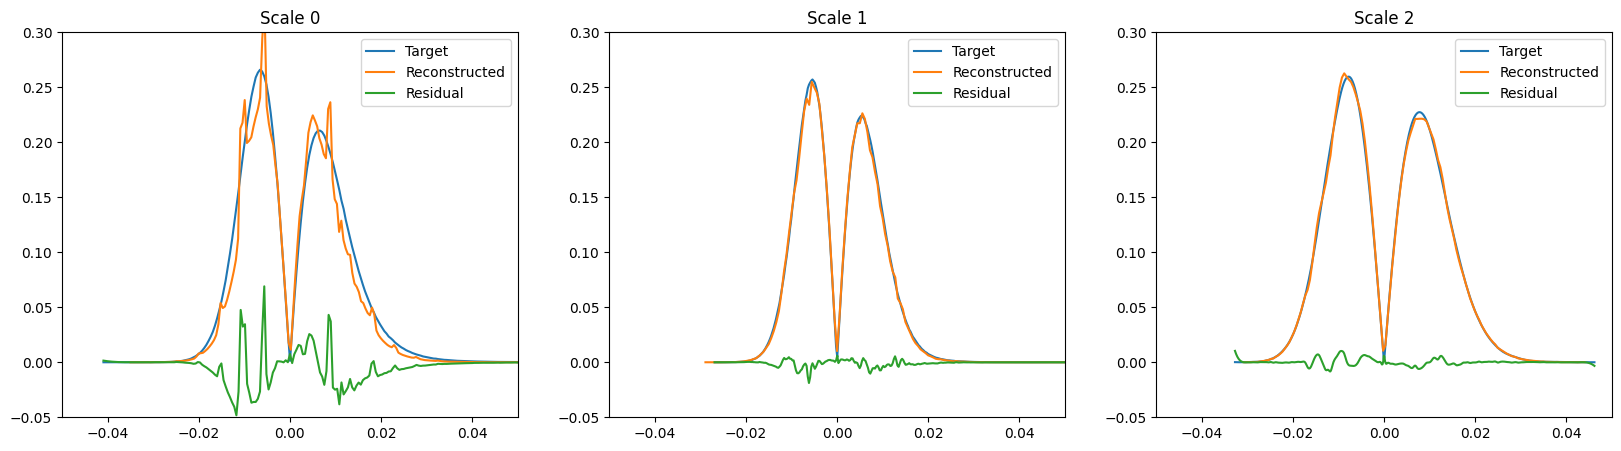

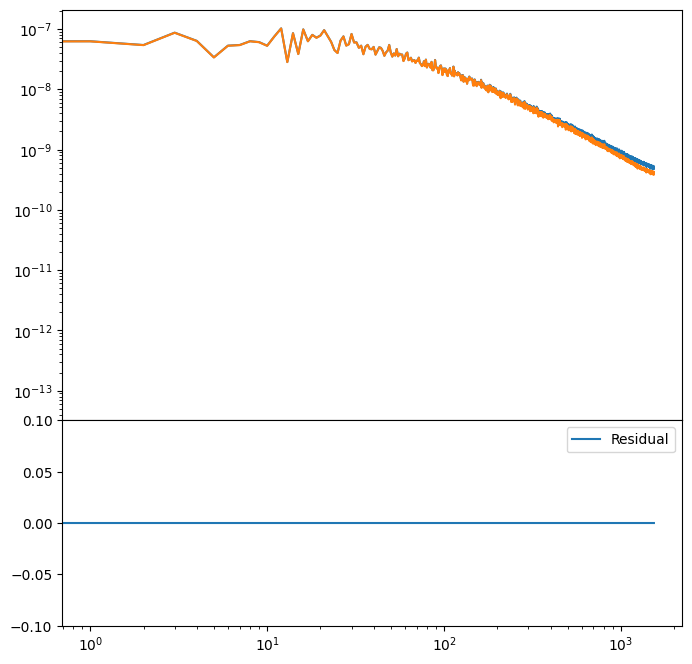

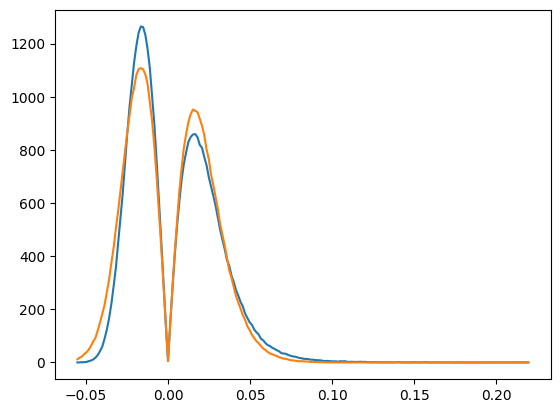

In [21]:
nside_target = 512
lmax_target = 3*nside_target + 1

kappa = downgrage_map(kappa_original, nside_target)

nside_map = nside_target
lmax_map = 3*nside_map +1

start_time = time.time()
map_gaussian = get_gaussian_map(nside_map, lmax_map)
end_time = time.time()
print(f"Time taken to generate gaussian map for nside: {nside_map} is, {end_time - start_time}s")

nscales = 2
nbins = [200,150,150,150,150]


solution = map_gaussian
pixel_res = hp.nside2resol(nside_map, arcmin=True)
beam_filters = [get_beam(pixel_res * (2**i), lmax_map) for i in range(0, nscales+1)]

tot_error = []
for i in range(250):
    solution_coefs = tophat_decompose_(solution, nside_map, lmax_map, nscales, beam_filters)
    # solution_coefs = tophat_decompose(solution, nside_map, lmax_map, pixel_res, nscales)
    tot_err = 0
    for scale in range(nscales+1):
        solution_coefs[scale], err = adjust_map_l1(solution_coefs[scale], None, target_values[f'scale_{scale}'])
        tot_err += err
    tot_error.append(tot_err*100 / (nscales + 1))      
    
    solution_l1 = np.sum(solution_coefs, axis=0)
    
    solution_l1 = wiener_deconvolution(kappa_smooth=solution_l1, beam=beam_filters[0], theory_cls=target_values['cls'], lmax=lmax_target, nside=nside_target,noise_cls=None )
    
    solution_cls = adjust_cls(nside_map, lmax_map, solution, target_values['ells'], target_values['cls'])

    solution = 0.5 * (solution_cls + solution_l1)

    # if i>10 and np.average(tot_error[-10:]) < 0.5:
    #     print("Reached Convergence")
    #     break

plt.figure(figsize=(4,4))
plt.plot(tot_error)
plt.show()

vmin = -0.08
vmax = 0.4
hp.mollview(solution, title="Solution",min=vmin, max=vmax, sub=(1,2,1), cmap='hsv')
hp.mollview(kappa, title="Target", min=vmin, max=vmax, sub=(1,2,2), cmap='hsv')
plt.show()

plt.figure(figsize=(10,5))
hp.gnomview(solution, rot=(30, -10), reso=5, xsize=500, title="Recovered", sub=(1,2,1), min=vmin, max=vmax, cmap='hsv')
hp.gnomview(kappa, rot=(30, -10), reso=5, xsize=500, title="kappa", sub=(1,2,2), min=vmin, max=vmax, cmap='hsv')
plt.show()

solution_values = process_image_(None, solution, nscales, nbins, nside_map, lmax_map, beam_filters)
# solution_values = process_image(None, solution, nscales, nbins, nside_map, lmax_map)

fig, axs = plt.subplots(1, nscales + 1, figsize=(20, 5))
for scale in range(nscales+1):
    sigma = np.std(solution_values['coefs'][scale])
    centers_target = target_values[f'scale_{scale}']['bincenters']
    centers_solution = solution_values[f'scale_{scale}']['bincenters']
    l1norm_target = target_values[f'scale_{scale}']['l1_norm']
    l1norm_solution = solution_values[f'scale_{scale}']['l1_norm']
    l1norm_solution_spline = CubicSpline(centers_solution, l1norm_solution)
    
    axs[scale].plot(target_values[f'scale_{scale}']['bincenters'], target_values[f'scale_{scale}']['l1_norm'], label='Target')
    axs[scale].plot(solution_values[f'scale_{scale}']['bincenters'], solution_values[f'scale_{scale}']['l1_norm'], label='Reconstructed')
    axs[scale].plot(centers_target, (l1norm_solution_spline(centers_target) - l1norm_target), label='Residual')
    axs[scale].set_title(f'Scale {scale}')
    axs[scale].legend()
    axs[scale].set_ylim(-0.05, 0.3)
    axs[scale].set_xlim(-0.05, 0.05)
plt.show()


plt.figure(figsize=(8, 8))
# Use GridSpec to define the layout with different heights and no gap
gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0)  # hspace=0 removes vertical gap
# First subplot (Cls Comparison)
ax1 = plt.subplot(gs[0])
target_ells = target_values['ells']
target_cls = target_values['cls']
solution_ells = solution_values['ells']
solution_cls = solution_values['cls']
solution_cls_spline = CubicSpline(solution_ells, solution_cls)
ax1.loglog(solution_values['ells'], solution_values['cls'], label="Target")
ax1.loglog(target_values['ells'], target_values['cls'], label="Reconstructed")

ax2 = plt.subplot(gs[1], sharex=ax1)
ax2.plot(target_ells, (solution_cls_spline(target_ells) - target_cls), label='Residual')
ax2.set_ylim(-0.1,0.1)
plt.legend()

plt.figure()
counts_kappa, bins_kappa = np.histogram(kappa, bins=200)
counts_solution, bins_solution = np.histogram(solution, bins=bins_kappa)
centers = 0.5 * (bins_kappa[:-1] + bins_kappa[1:])
plt.plot(centers, counts_kappa*np.abs(centers), label="Target")
plt.plot(centers, counts_solution*np.abs(centers), label="Solution")
plt.show()

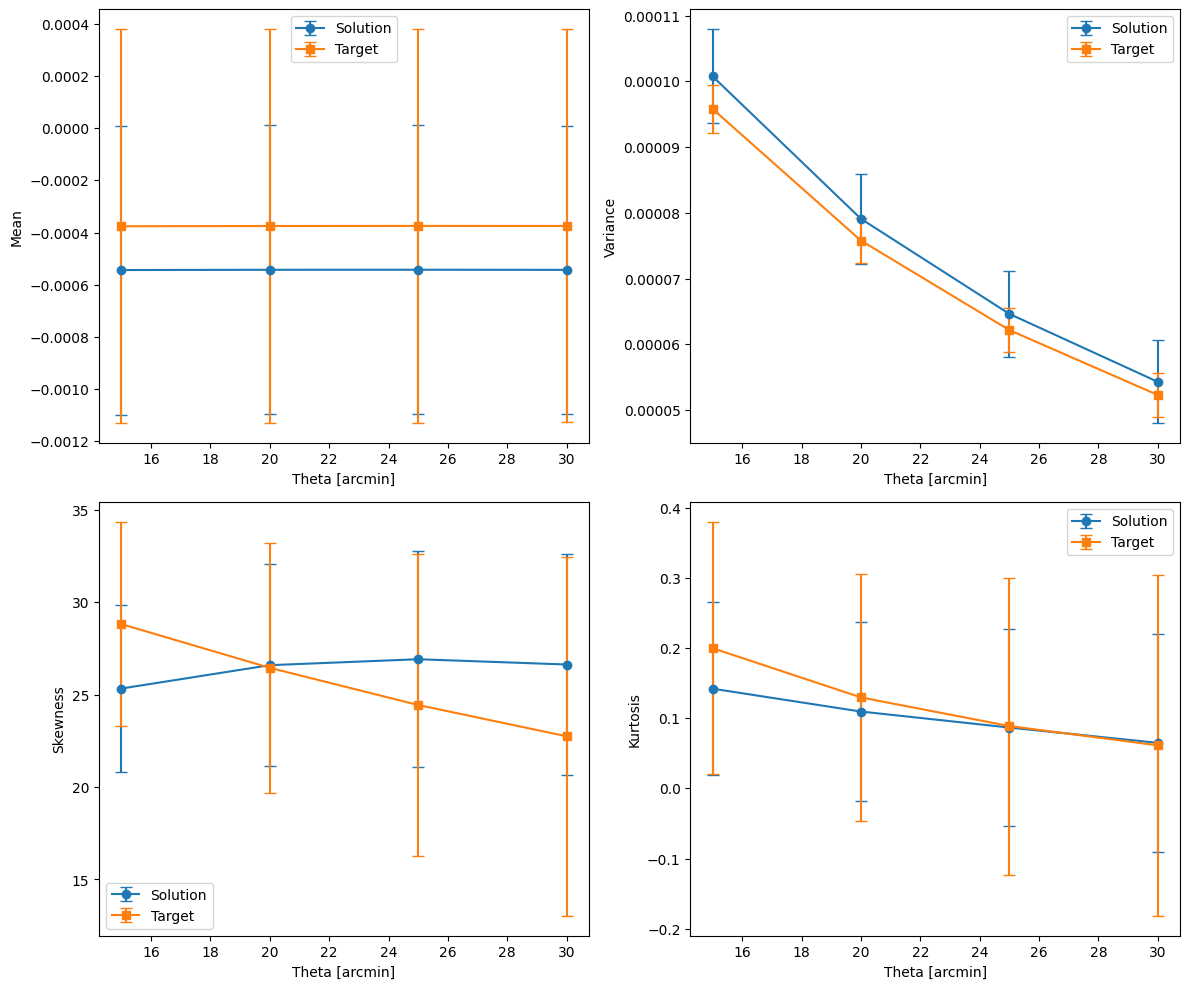

In [19]:
def get_top_hat_filtered_maps(map, nside, lmax, beam_filter):
    """Applies a top-hat filter to the map in harmonic space."""
    alm_map = hp.map2alm(map, lmax=lmax)
    alm_smooth = hp.almxfl(alm_map, beam_filter)
    map_smooth = hp.alm2map(alm_smooth, nside, lmax=lmax)
    return map_smooth

def get_moments_from_map(map_values):
    """
    Calculates the moments (mean, variance, skewness, kurtosis) from a 2D map.

    Parameters:
        map_values (numpy.ndarray): A 2D array representing the map values (e.g., convergence, density field).

    Returns:
        tuple: Contains mean, variance, skewness, kurtosis of the map values.
    """
    # Flatten the map to treat it as a distribution of values
    flattened_values = map_values.flatten()

    # Calculate the mean
    mean_value = np.mean(flattened_values)

    # Calculate the variance (second central moment)
    variance = np.var(flattened_values)

    # Calculate the third moment (skewness numerator)
    third_moment = np.mean((flattened_values - mean_value) ** 3)

    # Calculate the fourth moment (kurtosis numerator)
    fourth_moment = np.mean((flattened_values - mean_value) ** 4)

    # Skewness: third moment divided by variance squared
    skewness = third_moment / (variance ** 2)

    # Kurtosis: fourth moment divided by variance squared, minus 3 for excess kurtosis
    kurtosis = (fourth_moment / (variance ** 2)) - 3.0

    return mean_value, variance, skewness, kurtosis

def get_patch_variances(map_smooth, nside, npatches=6):
    """Divides the HEALPix map into patches and computes variance for each patch."""
    npix = hp.nside2npix(nside)
    base_nside = 3  # HEALPix base resolution (12 base pixels)
    
    # Select 6 patches from 12 base pixels
    patch_indices = [0, 1, 2, 3, 4, 5, 6]
    moments = []

    for base_pix in patch_indices:
        # Get boundaries (vertices) of the base pixel
        vertices = hp.boundaries(base_nside, base_pix, step=1, nest=False).T
        
        # Query pixels in this region
        pixels_in_patch = hp.query_polygon(nside, vertices, inclusive=True)

        # Compute variance in this patch
        patch_values = map_smooth[pixels_in_patch]
        moments.append(get_moments_from_map(patch_values))

    return moments  # Error estimate from patch variances

# Parameters
thetas = [ 15, 20, 25, 30]
beam_filters_th = [get_beam(thetas[i], lmax_target) for i in range(len(thetas))]

moments_solution = []
moments_target = []

for i in range(len(thetas)):
    # Compute for solution map
    map_smooth_sol = get_top_hat_filtered_maps(solution, nside_target, lmax_target, beam_filters_th[i])
    moments_sol = get_patch_variances(map_smooth_sol, nside_target)
    moments_solution.append(moments_sol)

    # Compute for target map
    map_smooth_tar = get_top_hat_filtered_maps(kappa, nside_target, lmax_target, beam_filters_th[i])
    moments_tar = get_patch_variances(map_smooth_tar, nside_target)
    moments_target.append(moments_tar)
    
moments_solution = np.array(moments_solution)
moments_target = np.array(moments_target)#

# Compute mean and standard deviation across patches for each theta
means_sol = np.mean(moments_solution, axis=1) 
errors_sol = np.std(moments_solution, axis=1)  

means_tar = np.mean(moments_target, axis=1) 
errors_tar = np.std(moments_target, axis=1)  

# Labels for the moments
moment_labels = ["Mean", "Variance", "Skewness", "Kurtosis"]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axs.flatten()):
    ax.errorbar(thetas, means_sol[:, i], yerr=errors_sol[:, i], label="Solution", fmt='o-', capsize=4)
    ax.errorbar(thetas, means_tar[:, i], yerr=errors_tar[:, i], label="Target", fmt='s-', capsize=4)
    ax.set_xlabel("Theta [arcmin]")
    ax.set_ylabel(moment_labels[i])
    ax.legend()

plt.tight_layout()
plt.show()

(7, 6, 4)